## Simple Deep Feed Forward Neural Network

In [147]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 
import datetime
from datetime import date, time

In [103]:
pd.set_option('display.max_columns', 500)

## Model

In [687]:
import torch.nn.functional as F

class LOBModel(nn.Module):
    def __init__(self, input_dim):
        super(LOBModel, self).__init__()
        self.layer1 = nn.Linear(input_dim, 512)
        self.layer2 = nn.Linear(512, 256)
        self.layer3 = nn.Linear(256, 512)
        self.layer4 = nn.Linear(512, 128)
        self.layer5 = nn.Linear(128, 64)
        self.layer6 = nn.Linear(64, 3)

        self.dropout = nn.Dropout(0.03)
        self.relu = nn.ReLU()
        self.norm1 = nn.InstanceNorm1d(512)
        self.norm2 = nn.InstanceNorm1d(256)
        self.norm3 = nn.InstanceNorm1d(512)

        self.leaky_relu = nn.LeakyReLU(negative_slope=0.01)

    def forward(self, x):
        x = self.norm1(self.leaky_relu(self.layer1(x)))
        x = self.dropout(x)
        x = self.norm2(self.leaky_relu(self.layer2(x)))
        x = self.dropout(x)
        x = self.norm3(self.leaky_relu(self.layer3(x)))
        x = self.dropout(x)
        x = self.leaky_relu(self.layer4(x))
        x = self.dropout(x)
        x = self.leaky_relu(self.layer5(x))
        x = self.layer6(x)
        x = F.softmax(x, dim=1)
        return x




### Data

In [688]:
train_data = pd.read_csv("data/Train_NoAuction_Zscore.csv")
train_data = train_data.filter(regex=("\_+"))


test_data = pd.read_csv("data/Test_NoAuction_Zscore.csv")
test_data = test_data.filter(regex=("\_+"))

In [689]:
batch_size = 64

X_train_data = train_data.drop(columns=['label_1', 'label_2', 'label_3', 'label_5', 'label_10'])
y_train_data = train_data[['label_1']]


X_train, X_val, y_train, y_val = train_test_split(X_train_data, y_train_data, test_size=0.2, random_state=42)

y_t = y_train.values
y_train_logits = np.zeros((len(y_t), 3))
for i in range(len(y_t)):
    y_train_logits[i, int(y_t[i, 0]) - 1] = 1

y_v = y_val.values
y_val_logits = np.zeros((len(y_v), 3))
for i in range(len(y_v)):
    y_val_logits[i, int(y_v[i, 0]) - 1] = 1



X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_logits, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val.values, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val_logits, dtype=torch.float32)


train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [690]:
y_train_tensor.shape

torch.Size([203800, 3])

### Training and Testing on different labels

In [691]:
def train_model(label="label_1", batch_size=64):    
    X_train_data = train_data.drop(columns=['label_1', 'label_2', 'label_3', 'label_5', 'label_10'])
    y_train_data = train_data[[label]]
    
    X_train, X_val, y_train, y_val = train_test_split(X_train_data, y_train_data, test_size=0.2, random_state=42)
    
    y_t = y_train.values
    y_train_logits = np.zeros((len(y_t), 3))
    for i in range(len(y_t)):
        y_train_logits[i, int(y_t[i, 0]) - 1] = 1
    
    y_v = y_val.values
    y_val_logits = np.zeros((len(y_v), 3))
    for i in range(len(y_v)):
        y_val_logits[i, int(y_v[i, 0]) - 1] = 1
    
    
    
    X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train_logits, dtype=torch.float32)
    X_val_tensor = torch.tensor(X_val.values, dtype=torch.float32)
    y_val_tensor = torch.tensor(y_val_logits, dtype=torch.float32)
    
    
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)




    model = LOBModel(X_train.shape[1])


    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-6)
    
    epochs=20
    
    
    train_losses = []
    val_losses = []
    
    for epoch in range(epochs):
        model.train()
        running_train_loss = 0.0
        
    
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            

            outputs = model(inputs)
            loss = criterion(outputs, targets)
            
            loss.backward()
            optimizer.step()
            
            running_train_loss += loss.item()
    
    
        avg_train_loss = running_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        
        model.eval()
        running_val_loss = 0.0
        
        with torch.no_grad():
            for inputs, targets in val_loader:
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                running_val_loss += loss.item()
        
        avg_val_loss = running_val_loss / len(val_loader)
        val_losses.append(avg_val_loss)
        
    
        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}")


    
    plt.figure(figsize=(10, 6))
    
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    
    plt.title(f'Training and Validation Loss for label={label}')
    plt.xlabel('Epochs')
    plt.ylabel('Loss (Cross-Entropy)')
    plt.legend()
    
    plt.grid(True)
    plt.show()
    

    X_test_data = test_data.drop(columns=['label_1', 'label_2', 'label_3', 'label_5', 'label_10'])
    y_test_data = test_data[[label]]
    
    
    # y_t = y_test_data.values
    # y_test_logits = np.zeros((len(y_t), 3))
    # for i in range(len(y_t)):
    #     y_test_logits[i, int(y_t[i, 0]) - 1] = 1
    
    
    X_test_tensor = torch.tensor(X_test_data.values, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test_data.values, dtype=torch.float32)
    
    
    test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

    model.eval()
    correct_predictions = 0
    total_predictions = 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, targets in test_loader:
            
            probabilities = model(inputs)
            
            _, predicted = torch.max(probabilities, 1)
            predicted = torch.add(predicted, 1)
            
    
            all_preds.extend(predicted.numpy())
            all_labels.extend(targets.numpy())
            
    
            # print(probabilities, predicted, targets.flatten())
            correct_predictions += (predicted == targets.flatten()).sum().item()
            total_predictions += targets.size(0)

    print(f"correct predictions: {correct_predictions:.4f}")
    print(f"total predictions: {total_predictions:.4f}")
    accuracy = correct_predictions / total_predictions
    print(f"Test Accuracy: {accuracy:.4f}")



    return model

/Users/talldarkandhandsome/.pyenv/versions/3.10.0/lib/python3.10/site-packages/torch/nn/modules/instancenorm.py:80: UserWarning: input's size at dim=0 does not match num_features. You can silence this warning by not passing in num_features, which is not used because affine=False
  warnings.warn(f"input's size at dim={feature_dim} does not match num_features. "


Epoch 1/20, Train Loss: 1.0110, Validation Loss: 0.9569
Epoch 2/20, Train Loss: 0.9469, Validation Loss: 0.9426
Epoch 3/20, Train Loss: 0.9392, Validation Loss: 0.9399
Epoch 4/20, Train Loss: 0.9373, Validation Loss: 0.9390
Epoch 5/20, Train Loss: 0.9365, Validation Loss: 0.9384
Epoch 6/20, Train Loss: 0.9361, Validation Loss: 0.9380
Epoch 7/20, Train Loss: 0.9356, Validation Loss: 0.9377
Epoch 8/20, Train Loss: 0.9353, Validation Loss: 0.9374
Epoch 9/20, Train Loss: 0.9350, Validation Loss: 0.9372
Epoch 10/20, Train Loss: 0.9348, Validation Loss: 0.9370
Epoch 11/20, Train Loss: 0.9346, Validation Loss: 0.9367
Epoch 12/20, Train Loss: 0.9342, Validation Loss: 0.9364
Epoch 13/20, Train Loss: 0.9340, Validation Loss: 0.9362
Epoch 14/20, Train Loss: 0.9338, Validation Loss: 0.9360
Epoch 15/20, Train Loss: 0.9336, Validation Loss: 0.9358
Epoch 16/20, Train Loss: 0.9334, Validation Loss: 0.9356
Epoch 17/20, Train Loss: 0.9333, Validation Loss: 0.9355
Epoch 18/20, Train Loss: 0.9332, Validat

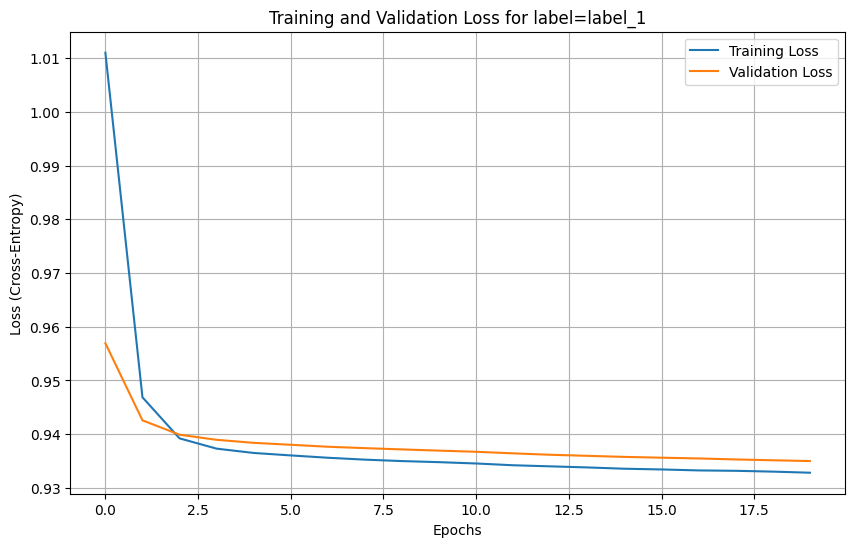

/Users/talldarkandhandsome/.pyenv/versions/3.10.0/lib/python3.10/site-packages/torch/nn/modules/instancenorm.py:80: UserWarning: input's size at dim=0 does not match num_features. You can silence this warning by not passing in num_features, which is not used because affine=False
  warnings.warn(f"input's size at dim={feature_dim} does not match num_features. "


correct predictions: 99027.0000
total predictions: 139587.0000
Test Accuracy: 0.7094


In [692]:
model_1 = train_model(label='label_1')


/Users/talldarkandhandsome/.pyenv/versions/3.10.0/lib/python3.10/site-packages/torch/nn/modules/instancenorm.py:80: UserWarning: input's size at dim=0 does not match num_features. You can silence this warning by not passing in num_features, which is not used because affine=False
  warnings.warn(f"input's size at dim={feature_dim} does not match num_features. "


Epoch 1/20, Train Loss: 1.0634, Validation Loss: 1.0415
Epoch 2/20, Train Loss: 1.0374, Validation Loss: 1.0341
Epoch 3/20, Train Loss: 1.0330, Validation Loss: 1.0322
Epoch 4/20, Train Loss: 1.0313, Validation Loss: 1.0308
Epoch 5/20, Train Loss: 1.0299, Validation Loss: 1.0297
Epoch 6/20, Train Loss: 1.0287, Validation Loss: 1.0286
Epoch 7/20, Train Loss: 1.0277, Validation Loss: 1.0277
Epoch 8/20, Train Loss: 1.0268, Validation Loss: 1.0269
Epoch 9/20, Train Loss: 1.0259, Validation Loss: 1.0260
Epoch 10/20, Train Loss: 1.0250, Validation Loss: 1.0254
Epoch 11/20, Train Loss: 1.0242, Validation Loss: 1.0245
Epoch 12/20, Train Loss: 1.0235, Validation Loss: 1.0238
Epoch 13/20, Train Loss: 1.0228, Validation Loss: 1.0234
Epoch 14/20, Train Loss: 1.0223, Validation Loss: 1.0226
Epoch 15/20, Train Loss: 1.0215, Validation Loss: 1.0220
Epoch 16/20, Train Loss: 1.0211, Validation Loss: 1.0215
Epoch 17/20, Train Loss: 1.0204, Validation Loss: 1.0210
Epoch 18/20, Train Loss: 1.0199, Validat

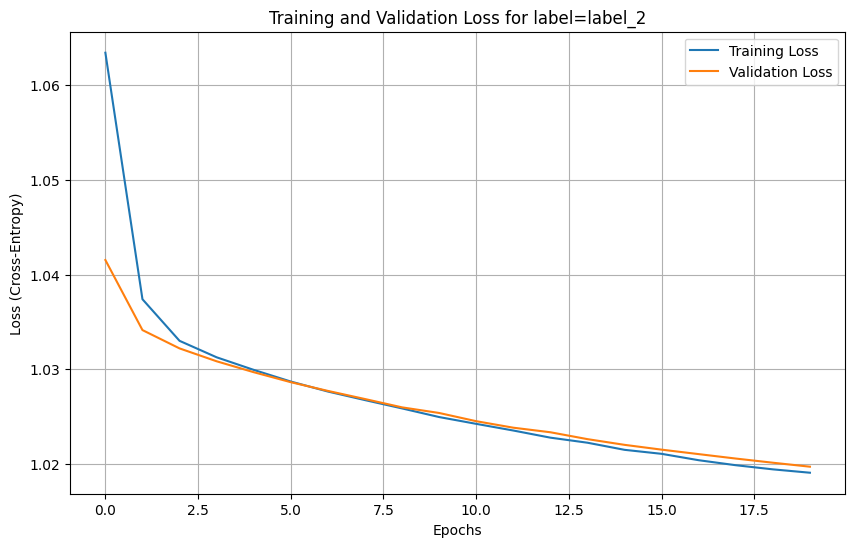

/Users/talldarkandhandsome/.pyenv/versions/3.10.0/lib/python3.10/site-packages/torch/nn/modules/instancenorm.py:80: UserWarning: input's size at dim=0 does not match num_features. You can silence this warning by not passing in num_features, which is not used because affine=False
  warnings.warn(f"input's size at dim={feature_dim} does not match num_features. "


correct predictions: 86827.0000
total predictions: 139587.0000
Test Accuracy: 0.6220


In [693]:
model_2 = train_model(label='label_2')


/Users/talldarkandhandsome/.pyenv/versions/3.10.0/lib/python3.10/site-packages/torch/nn/modules/instancenorm.py:80: UserWarning: input's size at dim=0 does not match num_features. You can silence this warning by not passing in num_features, which is not used because affine=False
  warnings.warn(f"input's size at dim={feature_dim} does not match num_features. "


Epoch 1/20, Train Loss: 1.0869, Validation Loss: 1.0767
Epoch 2/20, Train Loss: 1.0737, Validation Loss: 1.0717
Epoch 3/20, Train Loss: 1.0698, Validation Loss: 1.0688
Epoch 4/20, Train Loss: 1.0672, Validation Loss: 1.0665
Epoch 5/20, Train Loss: 1.0650, Validation Loss: 1.0644
Epoch 6/20, Train Loss: 1.0629, Validation Loss: 1.0624
Epoch 7/20, Train Loss: 1.0611, Validation Loss: 1.0607
Epoch 8/20, Train Loss: 1.0596, Validation Loss: 1.0593
Epoch 9/20, Train Loss: 1.0581, Validation Loss: 1.0580
Epoch 10/20, Train Loss: 1.0570, Validation Loss: 1.0570
Epoch 11/20, Train Loss: 1.0559, Validation Loss: 1.0560
Epoch 12/20, Train Loss: 1.0550, Validation Loss: 1.0551
Epoch 13/20, Train Loss: 1.0541, Validation Loss: 1.0542
Epoch 14/20, Train Loss: 1.0533, Validation Loss: 1.0534
Epoch 15/20, Train Loss: 1.0525, Validation Loss: 1.0526
Epoch 16/20, Train Loss: 1.0517, Validation Loss: 1.0518
Epoch 17/20, Train Loss: 1.0511, Validation Loss: 1.0511
Epoch 18/20, Train Loss: 1.0503, Validat

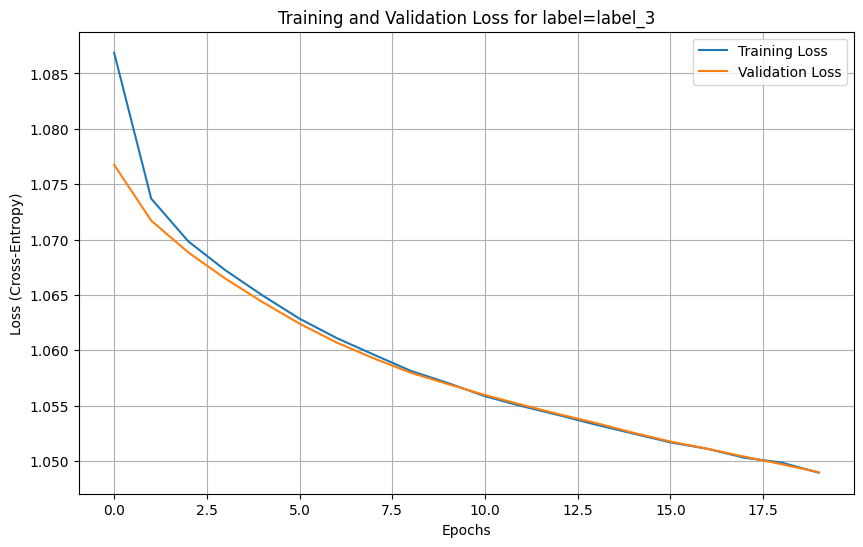

/Users/talldarkandhandsome/.pyenv/versions/3.10.0/lib/python3.10/site-packages/torch/nn/modules/instancenorm.py:80: UserWarning: input's size at dim=0 does not match num_features. You can silence this warning by not passing in num_features, which is not used because affine=False
  warnings.warn(f"input's size at dim={feature_dim} does not match num_features. "


correct predictions: 76039.0000
total predictions: 139587.0000
Test Accuracy: 0.5447


In [694]:
model_3 = train_model(label='label_3')


/Users/talldarkandhandsome/.pyenv/versions/3.10.0/lib/python3.10/site-packages/torch/nn/modules/instancenorm.py:80: UserWarning: input's size at dim=0 does not match num_features. You can silence this warning by not passing in num_features, which is not used because affine=False
  warnings.warn(f"input's size at dim={feature_dim} does not match num_features. "


Epoch 1/20, Train Loss: 1.0948, Validation Loss: 1.0906
Epoch 2/20, Train Loss: 1.0886, Validation Loss: 1.0853
Epoch 3/20, Train Loss: 1.0840, Validation Loss: 1.0812
Epoch 4/20, Train Loss: 1.0803, Validation Loss: 1.0781
Epoch 5/20, Train Loss: 1.0773, Validation Loss: 1.0756
Epoch 6/20, Train Loss: 1.0750, Validation Loss: 1.0736
Epoch 7/20, Train Loss: 1.0731, Validation Loss: 1.0717
Epoch 8/20, Train Loss: 1.0715, Validation Loss: 1.0702
Epoch 9/20, Train Loss: 1.0699, Validation Loss: 1.0686
Epoch 10/20, Train Loss: 1.0686, Validation Loss: 1.0671
Epoch 11/20, Train Loss: 1.0672, Validation Loss: 1.0658
Epoch 12/20, Train Loss: 1.0662, Validation Loss: 1.0645
Epoch 13/20, Train Loss: 1.0650, Validation Loss: 1.0634
Epoch 14/20, Train Loss: 1.0638, Validation Loss: 1.0624
Epoch 15/20, Train Loss: 1.0628, Validation Loss: 1.0610
Epoch 16/20, Train Loss: 1.0617, Validation Loss: 1.0599
Epoch 17/20, Train Loss: 1.0607, Validation Loss: 1.0588
Epoch 18/20, Train Loss: 1.0597, Validat

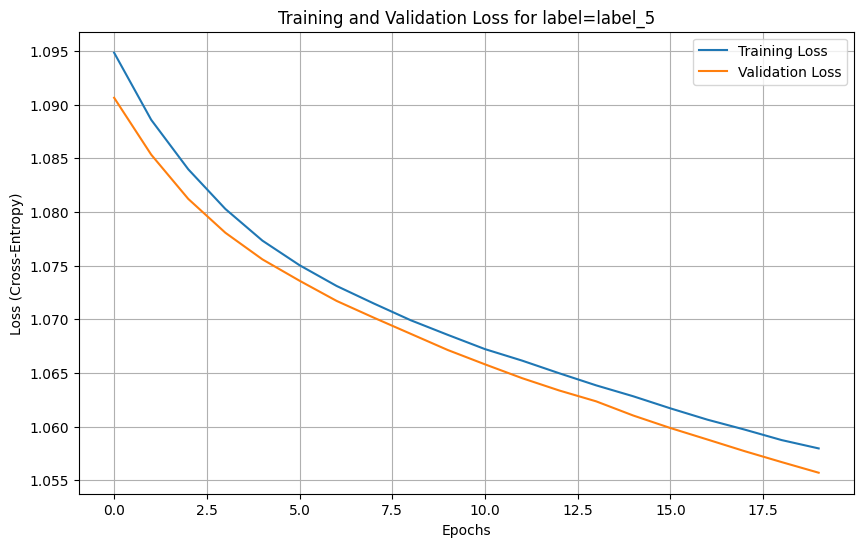

/Users/talldarkandhandsome/.pyenv/versions/3.10.0/lib/python3.10/site-packages/torch/nn/modules/instancenorm.py:80: UserWarning: input's size at dim=0 does not match num_features. You can silence this warning by not passing in num_features, which is not used because affine=False
  warnings.warn(f"input's size at dim={feature_dim} does not match num_features. "


correct predictions: 64012.0000
total predictions: 139587.0000
Test Accuracy: 0.4586


In [695]:
model_5 = train_model(label='label_5')


/Users/talldarkandhandsome/.pyenv/versions/3.10.0/lib/python3.10/site-packages/torch/nn/modules/instancenorm.py:80: UserWarning: input's size at dim=0 does not match num_features. You can silence this warning by not passing in num_features, which is not used because affine=False
  warnings.warn(f"input's size at dim={feature_dim} does not match num_features. "


Epoch 1/20, Train Loss: 1.0764, Validation Loss: 1.0610
Epoch 2/20, Train Loss: 1.0552, Validation Loss: 1.0490
Epoch 3/20, Train Loss: 1.0464, Validation Loss: 1.0428
Epoch 4/20, Train Loss: 1.0417, Validation Loss: 1.0396
Epoch 5/20, Train Loss: 1.0389, Validation Loss: 1.0376
Epoch 6/20, Train Loss: 1.0371, Validation Loss: 1.0360
Epoch 7/20, Train Loss: 1.0358, Validation Loss: 1.0346
Epoch 8/20, Train Loss: 1.0344, Validation Loss: 1.0334
Epoch 9/20, Train Loss: 1.0332, Validation Loss: 1.0319
Epoch 10/20, Train Loss: 1.0319, Validation Loss: 1.0307
Epoch 11/20, Train Loss: 1.0309, Validation Loss: 1.0294
Epoch 12/20, Train Loss: 1.0297, Validation Loss: 1.0282
Epoch 13/20, Train Loss: 1.0288, Validation Loss: 1.0271
Epoch 14/20, Train Loss: 1.0276, Validation Loss: 1.0261
Epoch 15/20, Train Loss: 1.0265, Validation Loss: 1.0250
Epoch 16/20, Train Loss: 1.0257, Validation Loss: 1.0240
Epoch 17/20, Train Loss: 1.0248, Validation Loss: 1.0230
Epoch 18/20, Train Loss: 1.0240, Validat

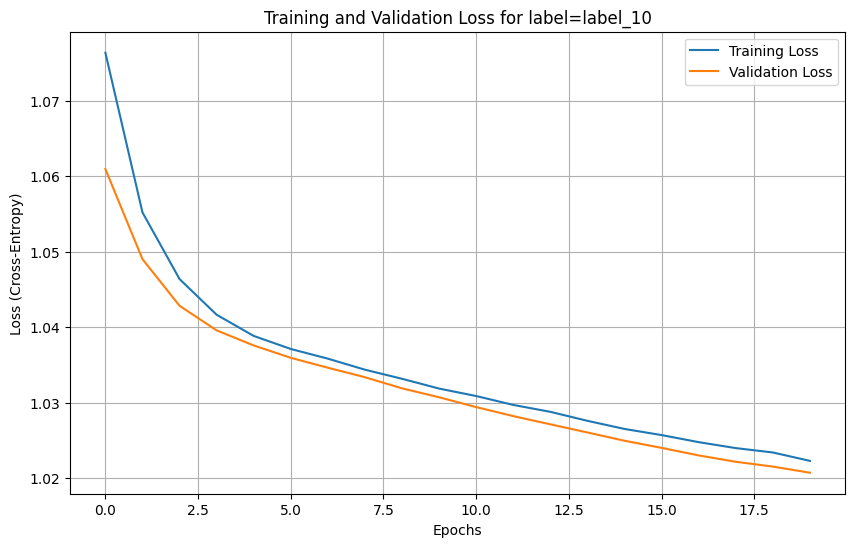

/Users/talldarkandhandsome/.pyenv/versions/3.10.0/lib/python3.10/site-packages/torch/nn/modules/instancenorm.py:80: UserWarning: input's size at dim=0 does not match num_features. You can silence this warning by not passing in num_features, which is not used because affine=False
  warnings.warn(f"input's size at dim={feature_dim} does not match num_features. "


correct predictions: 54493.0000
total predictions: 139587.0000
Test Accuracy: 0.3904


In [696]:
model_10 = train_model(label='label_10')


### Scratch

/Users/talldarkandhandsome/.pyenv/versions/3.10.0/lib/python3.10/site-packages/torch/nn/modules/instancenorm.py:80: UserWarning: input's size at dim=0 does not match num_features. You can silence this warning by not passing in num_features, which is not used because affine=False
  warnings.warn(f"input's size at dim={feature_dim} does not match num_features. "


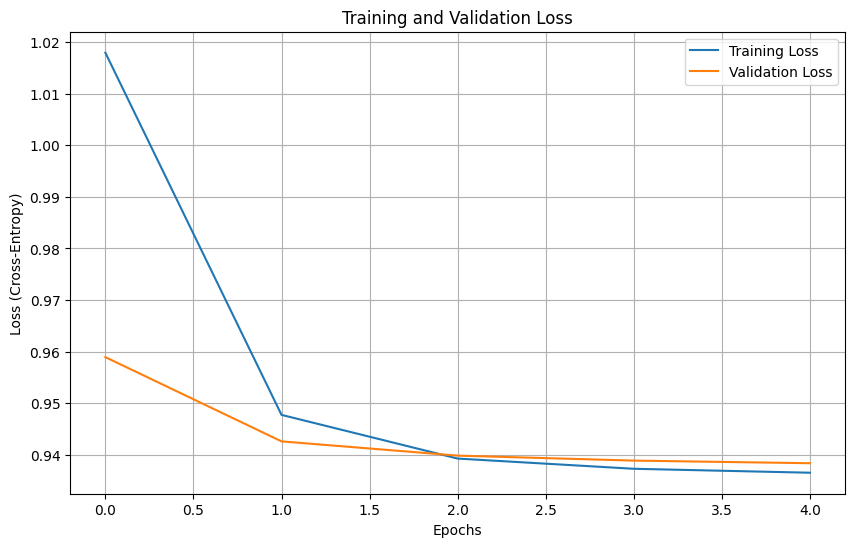

In [686]:
# torch.set_warn_always(False)

# model = LOBModel(X_train.shape[1])


# criterion = nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=1e-6)

# epochs=5


# train_losses = []
# val_losses = []

# for epoch in range(epochs):
#     model.train()
#     running_train_loss = 0.0
    

#     for inputs, targets in train_loader:
#         optimizer.zero_grad()
        
#         outputs = model(inputs)
#         loss = criterion(outputs, targets)
        
#         loss.backward()
#         optimizer.step()
        
#         running_train_loss += loss.item()


#     avg_train_loss = running_train_loss / len(train_loader)
#     train_losses.append(avg_train_loss)
    

#     model.eval()
#     running_val_loss = 0.0
    
#     with torch.no_grad():
#         for inputs, targets in val_loader:
#             outputs = model(inputs)
#             loss = criterion(outputs, targets)
#             running_val_loss += loss.item()
    
#     avg_val_loss = running_val_loss / len(val_loader)
#     val_losses.append(avg_val_loss)
    

#     # print(f"Epoch {epoch+1}/{epochs}, Train Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}")



# # Plot the training and validation loss curves
# plt.figure(figsize=(10, 6))

# plt.plot(train_losses, label='Training Loss')
# plt.plot(val_losses, label='Validation Loss')

# plt.title('Training and Validation Loss')
# plt.xlabel('Epochs')
# plt.ylabel('Loss (Cross-Entropy)')
# plt.legend()

# plt.grid(True)
# plt.show()